In [1]:
import sys 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
import torchvision 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from d2l import torch as d2l 
from tensorboardX import SummaryWriter
from scipy.io import savemat
from scipy.stats import spearmanr
import torch.nn.functional as F


In [ ]:
sys.path.append(r'D://projectcode//python//pytorch//DataProcessing') 
sys.path.append(r'D://projectcode//python//pytorch//utils') 
sys.path.append(r'D://projectcode//python//pytorch//NetDefine') 
sys.path.append(r'D://projectcode//python//pytorch//NetDefine//VAE') 

import LowpassFilter 
import MyDataSet 
import LSTM 
import VAE_test as vae 
import simDataprocess 
import time

In [ ]:
SEED= 1
np.random.seed(SEED) 
torch.manual_seed(SEED) 
torch.cuda.manual_seed_all(SEED) 
torch.backends.cudnn.deterministic=True 
torch.backends.cudnn.benchmark = False 

In [ ]:
ss = StandardScaler() 
dataset = "UR5ContactSim"
acc = 1       
if dataset == "UR5ContactSim": 
    df3 = pd.read_csv('pytorch/dataset/YangbenCeshiji41(2600).csv') 
    dof = 6 
df=np.array(df3) 

In [6]:
time_size = 10 
batch_size = 128 
train_joint = 5 

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
writer = SummaryWriter('./runs/LSTM/loss') 
testmode = "st" 


In [ ]:
if dataset == "UR5ContactSim": 
    
    [q,v,a,i,filt_q,filt_v,filt_a,filt_i,filt_qr,filt_dqr,filter_ddqr,filter_deltaq] = LowpassFilter.lowpass_filter5(df,dof,0.5) 
    train_number = 2600 
    test_number = 199 
    
    if acc == 0: 
        [train_input_tensor,train_output_tensor] = MyDataSet.TrainSet_withref(train_number,train_joint,filt_q,filt_v,filt_i,filt_qr,filt_dqr) 
        [test_input_tensor,test_output_tensor] = MyDataSet.TestSet_ref(train_number,train_joint,filt_q,filt_v,filt_i,filt_qr,filt_dqr) 
    else:
        [train_input_tensor,train_output_tensor] = MyDataSet.TrainSet_acc_withRef1(train_number,dof,filt_q,filt_v,filt_a,filt_i,filt_qr,filt_dqr,filter_ddqr,filter_deltaq) 
        [test_input_tensor,test_output_tensor] = MyDataSet.TestSet_acc_ref(train_number,dof,filt_q,filt_v,filt_a,filt_i,filt_qr,filt_dqr,filter_ddqr,filter_deltaq)
print(test_input_tensor.shape)
train = MyDataSet.MyDataSet_future1_oldref(train_input_tensor,train_output_tensor,time_size,dof,train_number) 
test = MyDataSet.MyDataSet_future1_oldref(test_input_tensor,test_output_tensor,time_size,dof,test_number) 

train_loader = DataLoader(train, batch_size) 
test_loader = DataLoader(test, batch_size) 

mean: [-0.3052184   0.22016226 -0.34878391  0.11885139 -0.12997305  0.11848069]
stds: [0.23142669 0.36368535 0.3185543  0.08605581 0.08193156 0.09802703]
mean: [-0.3052184   0.22016226 -0.34878391  0.11885139 -0.12997305  0.11848069]
stds: [0.23142669 0.36368535 0.3185543  0.08605581 0.08193156 0.09802703]
torch.Size([199, 36])


In [ ]:
num_epochs = 150 #1000 epochs n 
learning_rate = 0.01 #0.001 lr 
input_size =2*dof 
hidden_size = 5 #number of features in hidden state 
num_layers = 1 #number of stacked lstm layers 
num_classes = 1 #number of output classes 
criterion = torch.nn.MSELoss() # mean-squared error for regression 

lstm = LSTM.ContactComp_Implicated(num_classes, 1, input_size, hidden_size, num_layers, time_size,dof).to(device) 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) #, weight_decay=0.0001, weight_decay=0.01, weight_decay=0.0001 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.8,patience=2,cooldown=1,threshold=0.100,min_lr=0.001) 

In [ ]:
train_loss = np.zeros((1,num_epochs)) 
mylist = [0,1,2,3,4,5,6,7,8,9,10,11]#[0,1,2,3,4,5,6,7,8,9,10,11,12,13] 
pcorr = np.zeros((2*dof)) 
rcorr = np.zeros((2*dof)) 
corr_array = np.zeros((1,num_epochs)) 
min_std =0.1 
std_scale = 1 
total_train_time = 0.0

train_start = time.time()
for epoch in range(num_epochs): 
    running_loss = 0.0 
    epoch_start = time.time()
    cos_sim_reg = 0.0 
    lstm.train() 
    for step, (batch_x, batch_y,label1,future_data,oldref) in enumerate(train_loader): 
        step_start = time.time()
        outputs,sa,ta,error,total_tau  = lstm.forward(batch_x,train_joint,future_data,oldref) #forward pass,PLSR(batch_x,batch_y[:,train_joint]) 
        


        
        sa_per_batch = sa.std(dim=[1], keepdim=False) 
        sa_std_loss = torch.max(sa_per_batch) 
        sa_std_loss = torch.log(sa_std_loss / 0.01 + 1) * std_scale 


        loss = criterion(outputs[:,0], batch_y[:,train_joint])+sa_std_loss
        optimizer.zero_grad() #caluclate the gradient, manually setting to 00 
        loss.backward() #calculates the loss of the loss function 
        optimizer.step() #improve from loss, i.e backprop 
        running_loss += loss.item() 
    epoch_time = time.time() - epoch_start
    total_train_time += epoch_time
    corr_array = np.append(corr_array,(cos_sim_reg / len(train_loader))) 
    writer.add_scalar("train loss",loss,epoch) 
    scheduler.step(running_loss / len(train_loader)) 
    train_loss = np.append(train_loss,(running_loss / len(train_loader))) 
    if epoch % 10 == 0: 
        print("Epoch: %d, loss:%1.5f" % (epoch, running_loss / len(train_loader))) 
        print(f"\nepoch Training Time: {epoch_time:.2f}s")
total_time = time.time() - train_start
print(f"\nTotal Training Time: {total_time:.2f}s")
torch.save(lstm.state_dict(), 'model_contact_state_dict'+"_joint_"+str(train_joint)+'.pth') 
matstr = str(dataset)+"_joint_"+str(train_joint)+"cos_sim"+".mat" 
savemat(matstr,{'cos_sim':corr_array}) 
writer.close() 

D:\/projectcode//python//pytorch//DataProcessing\MyDataSet.py:432: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  para = torch.tensor(self.input[self.number-1,3*self.dof:5*self.dof]).repeat(item + 2*self.seq_len-self.number,1).reshape(item + 2*self.seq_len-self.number,furture_data1.size(1))


Epoch: 0, loss:3.39964

epoch Training Time: 0.17s
Epoch: 10, loss:0.82766

epoch Training Time: 0.15s
Epoch: 20, loss:0.65348

epoch Training Time: 0.15s
Epoch: 30, loss:0.52317

epoch Training Time: 0.15s
Epoch: 40, loss:0.38851

epoch Training Time: 0.15s
Epoch: 50, loss:0.33493

epoch Training Time: 0.15s
Epoch: 60, loss:0.30114

epoch Training Time: 0.16s
Epoch: 70, loss:0.26847

epoch Training Time: 0.16s
Epoch: 80, loss:0.26303

epoch Training Time: 0.15s
Epoch: 90, loss:0.25956

epoch Training Time: 0.14s
Epoch: 100, loss:0.24061

epoch Training Time: 0.14s
Epoch: 110, loss:0.24679

epoch Training Time: 0.16s
Epoch: 120, loss:0.25108

epoch Training Time: 0.16s
Epoch: 130, loss:0.24448

epoch Training Time: 0.16s
Epoch: 140, loss:0.23921

epoch Training Time: 0.15s

Total Training Time: 23.41s



Step Training Time: 0.003s
0
tensor(-0.5056, grad_fn=<MeanBackward0>)

Step Training Time: 0.003s
1
tensor(-0.9179, grad_fn=<MeanBackward0>)
j: 2
final_loss: tensor(0.0023)
(199, 6)
(199,)


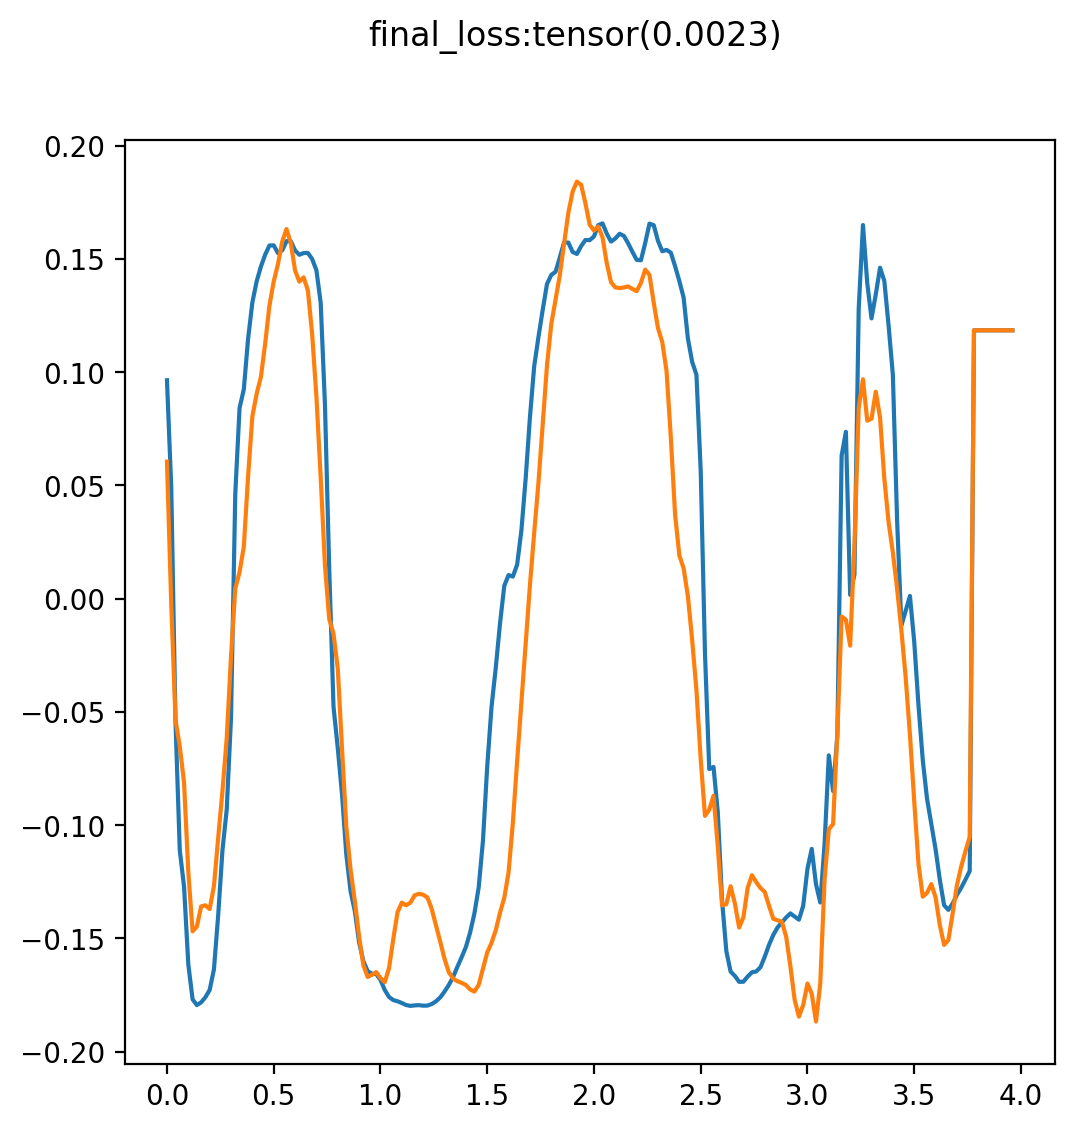

In [ ]:
if dataset == "UR5ContactSim": 
    a1 = np.zeros((199,dof)) 
    b1 = np.zeros((199,dof)) 
    
i = 0 
j = 0 
final_loss = 0 


sa_array = np.empty([127,batch_size,6],float) #BiLSTM 
ta_array = np.empty([127,batch_size,5],float) #BiLSTM 
vel_weight_array = np.empty([127,batch_size,2*hidden_size],float) #BiLSTM 

step_pcurve = np.empty([127,batch_size],float) 
step_rcurve = np.empty([127,batch_size],float) 
model = LSTM.LSTM_st_Attention_Bi3(num_classes, input_size, hidden_size, num_layers, time_size,dof).to(device) 

lstm.eval() 

for step, (batch_x, batch_y,label1,future_data,oldref) in enumerate(test_loader): 
    step_start = time.time()
    outputs,sa,ta,error,total_tau = lstm.forward(batch_x,train_joint,future_data,oldref) 
    step_time = time.time() - step_start
    loss = criterion(outputs[:,0], batch_y[:,train_joint]) 
    final_loss = final_loss + loss 
    j = j+1 
    a1[i:(i+outputs[:,0].shape[0]),0] = outputs[:,0].data.cpu().numpy() 
    b1[i:(i+outputs[:,0].shape[0]),0] = batch_y[:,train_joint].data.cpu().numpy() 
    atten_shape = outputs.data.cpu().numpy().shape[0] 
    step_pcurve[step,0:(atten_shape)] = outputs[:,0].data.cpu().numpy() 
    step_rcurve[step,0:(atten_shape)] = batch_y[:,train_joint].data.cpu().numpy() 
    ta_array[step,0:(atten_shape),:]=ta.data.cpu().numpy() 
    sa_array[step,0:(atten_shape),:]=sa.data.cpu().numpy() 
    i = i + outputs[:,0].shape[0] 
    
    print(f"\nStep Training Time: {step_time:.4f}s")
    print(step) 
    merror = torch.mean(error) 
    print(merror) 
    
#41   
mean=[-0.3052184,   0.22016226, -0.34878391,  0.11885139, -0.12997305, 0.11848069]
stds= [0.23142669, 0.36368535, 0.3185543,  0.08605581, 0.08193156, 0.09802703]

#38
# mean= [ 0.36960001, -0.11197057, -0.54501112,  0.16625633, -0.03268282,  0.00417673]
# stds= [0.41061126, 0.6474014,  0.41463597, 0.23149997, 0.15445075, 0.18252268]

#42
# mean: [-0.30982867  0.22078299 -0.3483509   0.1219021  -0.13184341  0.11608114]
# stds: [0.22582578 0.36116726 0.32127016 0.08057154 0.0800937  0.10141024]

for i in range(199): 
    a1[i,0] = (a1[i,0]*stds[train_joint])+mean[train_joint] 
for i in range(199): 
    b1[i,0] = (b1[i,0]*stds[train_joint])+ mean[train_joint] 

final_loss = criterion(torch.tensor(a1[:,0], dtype=torch.float32),torch.tensor(b1[:,0], dtype=torch.float32)) 
print('j:',j) 
print('final_loss:', final_loss) 
print(a1.shape) 
time = np.arange(0,a1.shape[0]*0.02,0.02) 
print(time.shape) 
    
plt.figure(figsize=(6,6)) 
plt.plot(time,a1[:,0]) 
plt.plot(time,b1[:,0]) 

matstr = str(dataset)+"_joint_"+str(train_joint)+"_estimatedComp"+".mat" 
savemat(matstr,{'RCdata':a1[:,0]}) 
matstr = str(dataset)+"_joint_"+str(train_joint)+"_Realerror"+".mat" 
savemat(matstr,{'PCdata':b1[:,0]}) 

plt.suptitle("final_loss:"+str(final_loss)) 
plt.savefig("LSTM_PCA_TIME_Attention_joint2_150epoch_30timesize.svg",format="svg") 